# Problem statement

CSE department has a teaching assistant (TA) who helps undergraduate students with their programming assignments during regular office hours. The TA’s office is rather small and has room for only one desk with a chair and computer. There are three chairs in the hallway outside the office where students can sit and wait if the TA is currently helping another student. When there are no students who need help during office hours, the TA sits at the desk and takes a nap. If a student arrives during office hours and finds the TA sleeping, the student must awaken the TA to ask for help. If a student arrives and finds the TA currently helping another student, the student sits on one of the chairs in the hallway and waits. If no chairs are available, the student will come back at a later time. Using POSIX threads, mutex locks, and semaphores, implement a solution that coordinates the activities of the TA and the student.

# Specs

## Functional Specs

Simulating an office hour period using threads.

### constrains

- The TA office has capacity for only 1 student
- The hallway has a capacity for only 3 students
- The TA takes nap whenever there are no students to help
- Students shall wake up the TA if he were asleep
- If the hallway is full whenever a student arrives he shall leave and come latter

# Problem Decomposition

## Modeling Wise

The problem falls loosely into the stochastic simulation, precisely the M/G/1 queue; students arrive to the office according to a Poisson distribution with rate of λ student/time, time required for students by the TA  [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) random variables with mean τ and standard deviation σ time units.

For sake of simplification the assumption that students arrive at a i.i.d. times is taken but realistically students are more likely to appear in groups whenever the is a gap time between lectures. Even the [Inspection Paradox](http://allendowney.blogspot.com/2015/08/the-inspection-paradox-is-everywhere.html) is ignored. The simulation is not concerned with the failure point of the system, therefore, estimators calculations are ignored. The main focus is on the implementation technique with threads.

## Implementation Wise

- The problem is a `producer-consumer` threading problem with a **single** consumer(TA) and FIFO service for a **single** producer(hallway) and students are the modeled as packets.
- Analysis of the model is done in this notebook with interactive version can be found [here](https://colab.research.google.com/drive/1yB8ASOHD_GYdQ6q2btwUBmdMgdMIUoCW?usp=sharing).

### Simulation

- `office_hour.py`: Impelmentation for the producer-consumer problem.

# Model
In this section a model withe the assumptions stated in [3.1](#Modeling-Wise) is inspected.

In [1]:
import numpy as np
import pandas as pd
from scipy.special import factorial

import matplotlib.pyplot as plt


np.random.seed(42)

plt.style.use('seaborn')
%matplotlib inline

## Students/office hour

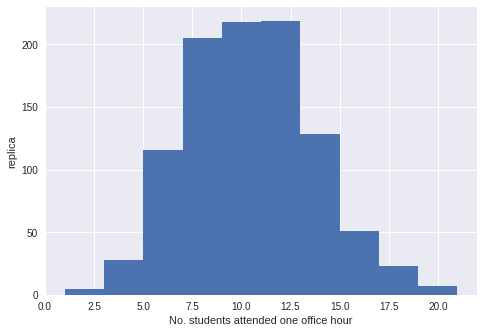

In [2]:
# 10 students are expected to show up during an office hour
# therefore expecting a single student to showup every 3 minutes

students_per_minute = 1/6

# assuming a 1h office hour session
minutes = 60

# simulate 1000 office hours
lmbda = students_per_minute * minutes
xs = np.random.poisson(lmbda, 1000)

fig = plt.figure()
ax = fig.add_axes((0.5, 4,1, 1))


ax.set_xlabel('No. students attended one office hour')
ax.set_ylabel('replica')

hist = ax.hist(xs)


## Gap time

The mean arrival time is 6.049243799153055 minutes


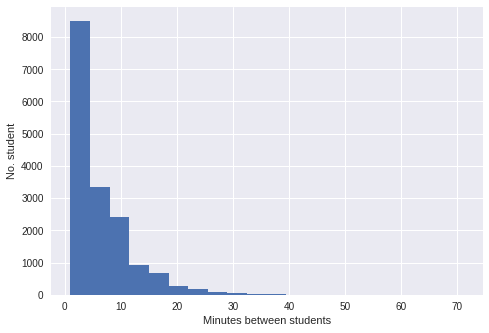

In [3]:
# intervals between students arrivals for 100000 student simulation


arrivals = np.diff(np.where(
        np.random.choice([0, 1], size = 100000, replace=True,
                         p=[1-students_per_minute, students_per_minute]) == 1)[0])
print(f'The mean arrival time is {arrivals.mean()} minutes')

fig = plt.figure()
ax = fig.add_axes((0.5, 4, 1, 1))

ax.set_xlabel('Minutes between students')
ax.set_ylabel('No. student')
hist = ax.hist(arrivals, bins=20)


## PDF 

The most likely value is 9 minutes with probability 0.1251


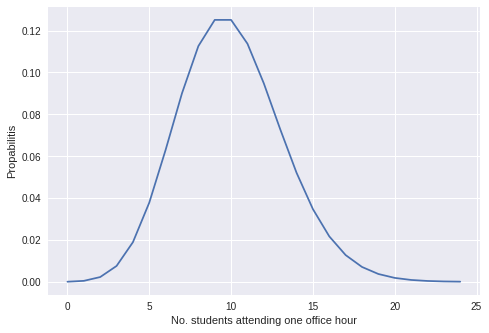

In [4]:
# probability of N of student attend one office hour

def calc_prob(events_per_minute, minutes, k):
    # Calculate probability of k events in specified number of minutes
    lam = events_per_minute * minutes
    return np.exp(-lam) * np.power(lam, k) / factorial(k)


ns = np.arange(25)
p_n = calc_prob(students_per_minute, minutes, ns)
print(f'The most likely value is {np.argmax(p_n)} minutes with probability {np.max(p_n):.4f}')

fig =  plt.figure()
ax = fig.add_axes((0.5, 4, 1, 1))

ax.set_xlabel('No. students attending one office hour')
ax.set_ylabel('Propabilitis')

plot = ax.plot(ns, p_n)

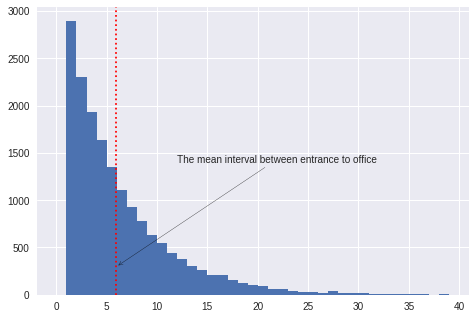

In [5]:
# The waiting time for students

arrivals = np.random.choice([0, 1], size=100000, replace=True, p=[1-students_per_minute, students_per_minute])
success_time = np.where(arrivals == 1)[0]
waititng_time = np.diff(success_time)
np.mean(waititng_time)

fig = plt.figure()
ax = fig.add_axes((0.5, 4, 1, 1))
ax.axvline(waititng_time.mean(), color='red', linestyle='dotted')
ax.annotate(
    'The mean interval between entrance to office',
    xy=(6, 300), arrowprops=dict(arrowstyle='->'), xytext=(12, 1400))
hist = ax.hist(waititng_time, bins=np.arange(40))


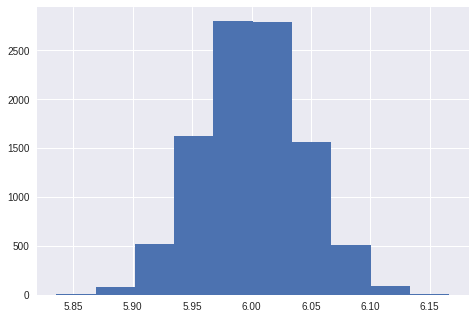

In [6]:
# average waiting time between students

avg = [np.mean(np.diff(np.where(
                       np.random.choice([0, 1], size = 100000,replace=True,
                       p=[1-students_per_minute, students_per_minute]) == 1)[0]))
       for _ in range(10000)]

fig = plt.figure()
ax = fig.add_axes((0.5, 4, 1, 1))
hist = ax.hist(avg)

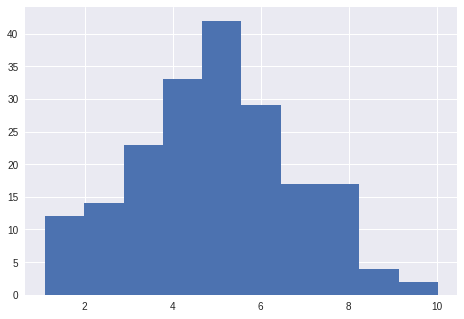

In [7]:
# normal disribution for time intevals The T.A. spends with each student

arr = np.random.normal(loc=5, scale=2, size=200)
arr = arr[arr >= 1]

fig = plt.figure()
ax = fig.add_axes((0.5, 4, 1, 1))
hist = ax.hist(arr)

# Impelmentation
python's threading module provides a wrapper around pthreads, each function call has its equivalent pthread function as a comment next to it.

In [8]:
import concurrent.futures
import logging
import threading
from collections import deque
from time import time, sleep
from typing import Literal, Generator

import numpy as np

np.random.seed(0)


class Simulation:
    def __init__(self, simulation_period: int, students_per_hour):
        self.interval_inside_office = self.t_spent_with_TA()
        self.interval_between_student_arrival = self.t_between_student_arrival()

        self.students_ids = self.generate_id()
        self.hallway = deque()
        self.TA_status: Literal['asleep', 'busy'] = 'asleep'

        self.TA_lock = threading.Lock()
        self.hallway_lock = threading.Lock()

        self.simulation_start_time = time()
        self.simulation_period = simulation_period
        self.students_per_hour = students_per_hour

    def student_arrives(self):
        """Simulate a student arrival event.
        Students arrive according to the distribution described in the previous
        sections
        """
        total_arrival_time = next(self.interval_between_student_arrival)
        while time() < self.simulation_start_time + self.simulation_period:
            if time() >= total_arrival_time + self.simulation_start_time:

                # when a student arrives the hallway queue gets acquired,
                # preventing race conditions.
                
                # equivalent to `pthread_mutex_lock`
                self.hallway_lock.acquire()  
                
                student_id = self.students_ids()
                logging.info('%s has arrived.', student_id)

                if self.TA_status == 'asleep':
                    logging.info('%s waked up the TA.', student_id)
                    self.hallway.append(student_id)

                elif len(self.hallway) < 3:
                    logging.info('%s found the TA busy, he is waiting in the hallway.', student_id)
                    self.hallway.append(student_id)

                    pronoun = 'are' if len(self.hallway) > 1 else 'is'
                    logging.info('there %s %s student(s) waiting in the hallway.',
                                 pronoun, len(self.hallway))
                else:
                    logging.info('%s has found the hallway full. he leaved.',
                                 student_id)
                # equivalent to `pthread_mutex_unlock`
                self.hallway_lock.release()
                
                # after deciding whether the student will 
                # wakeup the TA, wait, or leave
                # lock gets released.

                total_arrival_time += next(
                    self.interval_between_student_arrival)

    def student_enters_office(self):
        while time() < self.simulation_start_time + self.simulation_period:
            if len(self.hallway) > 0:
                # there're students in the hallway and the student spent
                self.TA_status = 'busy'
                next_office_time = next(self.interval_inside_office)

                self.hallway_lock.acquire()
                student_id = self.hallway.popleft()
                logging.info('%s entered the office.', student_id)
                self.hallway_lock.release()

                self.TA_lock.acquire()
                # sleep here is a builtin function to simulate the TA being busy
                # helping a student not asleep
                sleep(next_office_time)
                logging.info('%s left the office.', student_id)
                self.TA_lock.release()
            else:
                self.TA_status = 'asleep'

    @staticmethod
    def t_spent_with_TA() -> Generator[float, None, None]:
        intervals = np.random.normal(loc=5, scale=2, size=200)
        intervals = intervals[intervals >= 1]
        yield from list(intervals)

    def t_between_student_arrival(self) -> Generator[float, None, None]:
        students_per_minute = self.students_per_hour / 60
        arrivals = np.diff(np.where(
            np.random.choice([0, 1], size=200, replace=True,
                             p=[1 - students_per_minute,
                             students_per_minute]) == 1)[0])
        yield from list(arrivals)

    @staticmethod
    def generate_id():
        students_list = [0]

        def _generator():
            id_ = students_list[-1]
            students_list.append(id_ + 1)
            return f'student {students_list[-1]}'

        return _generator

    def run(self):
        logging.info('Simulation started...')
        logging.info('*' + 25 * '-' + '*')
        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
            # equivalent to `pthread_create; pthread_join`
            executor.submit(self.student_arrives)
            executor.submit(self.student_enters_office)
        logging.info('*' + 25 * '-' + '*')
        logging.info('Simulation period ended.')

# Results

In [9]:
fmt = "%(asctime)s: %(message)s"
logging.basicConfig(format=fmt, level=logging.INFO, datefmt="%H:%S")

## Simulating 10 students/h

In [10]:
s1 = Simulation(60, 10)
s1.run()

17:35: Simulation started...
17:35: *-------------------------*
17:36: student 1 has arrived.
17:36: student 1 waked up the TA.
17:36: student 1 entered the office.
17:41: student 2 has arrived.
17:41: student 2 found the TA busy, he is waiting in the hallway.
17:41: there is 1 student(s) waiting in the hallway.
17:43: student 1 left the office.
17:43: student 2 entered the office.
17:46: student 2 left the office.
17:47: student 3 has arrived.
17:47: student 3 waked up the TA.
17:47: student 3 entered the office.
17:48: student 4 has arrived.
17:48: student 4 found the TA busy, he is waiting in the hallway.
17:48: there is 1 student(s) waiting in the hallway.
17:50: student 3 left the office.
17:50: student 4 entered the office.
17:54: student 4 left the office.
17:55: student 5 has arrived.
17:55: student 5 waked up the TA.
17:55: student 5 entered the office.
17:59: student 5 left the office.
17:06: student 6 has arrived.
17:06: student 6 waked up the TA.
17:06: student 6 entered th

## Simulating 20 students/h

In [11]:
s2 = Simulation(60, 20)
s2.run()

17:35: Simulation started...
17:35: *-------------------------*
17:38: student 1 has arrived.
17:38: student 1 waked up the TA.
17:38: student 1 entered the office.
17:40: student 2 has arrived.
17:40: student 2 found the TA busy, he is waiting in the hallway.
17:40: there is 1 student(s) waiting in the hallway.
17:41: student 1 left the office.
17:41: student 2 entered the office.
17:41: student 3 has arrived.
17:41: student 3 found the TA busy, he is waiting in the hallway.
17:41: there is 1 student(s) waiting in the hallway.
17:42: student 4 has arrived.
17:42: student 4 found the TA busy, he is waiting in the hallway.
17:42: there are 2 student(s) waiting in the hallway.
17:43: student 5 has arrived.
17:43: student 5 found the TA busy, he is waiting in the hallway.
17:43: there are 3 student(s) waiting in the hallway.
17:44: student 6 has arrived.
17:44: student 6 has found the hallway full. he leaved.
17:45: student 7 has arrived.
17:45: student 7 has found the hallway full. he le

## Concurrency Diagrams for Simulation
### Sim 10 students/hour

![concurrency diagram 1](cd2.png)

### Sim 20 students/hour

![concurrency diagram 2](cd1.png)

## call Diagram

![call diagram 2](call_diagram.png)

# References

- Modern Operating Systems 4th Edition , © Pearson® 2015.
- [Concurrency Primitives From Scratch](https://isocpp.org/blog/2019/12/multithreading-101-concurrency-primitives-from-scratch-arvid-gerstmann-meet).
- B.L. Nelson, Foundations and Methods of Stochastic Simulation: A First Course,
International Series in Operations Research & Management Science 187,
DOI 10.1007/978-1-4614-6160-9 2, © Springer Science+Business Media New York 2013.
- Design of Multithreaded Software: The Entity-Life Modeling Approach, Bo I. Sanden.
- [The Inspection Paradox](http://allendowney.blogspot.com/2015/08/the-inspection-paradox-is-everywhere.html).
- [Why My Bus is Always Late](http://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/).